In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import pickle

In [4]:
with open('./pkl_files/cropped/carpal/validation/val_data.pkl', 'rb') as f:
    X_val_carpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/metacarpal/validation/val_data.pkl', 'rb') as f:
    X_val_metacarpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/validation/val_data_age.pkl', 'rb') as f:
    y_val = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/validation/val_data_gender.pkl', 'rb') as f:
    gender_val = np.array(pickle.load(f))



# bone_age_val = np.array(val_bone_age_arr)
# gender_val = np.array(val_gender_arr)

In [5]:
with open('./pkl_files/cropped/carpal/training/train_data.pkl', 'rb') as f:
    X_train_carpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/metacarpal/training/train_data.pkl', 'rb') as f:
    X_train_metacarpal = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/training/train_data_age.pkl', 'rb') as f:
    y_train = np.array(pickle.load(f))
with open('./pkl_files/cropped/gender_age/training/train_data_gender.pkl', 'rb') as f:
    gender_train = np.array(pickle.load(f))


# images_arr_train = np.array(train_img_arr)
# bone_age_train = np.array(train_bone_age_arr)
# gender_train = np.array(train_gender_arr)

In [6]:
y_train1 = y_train
y_train = (y_train-np.min(y_train))/(np.max(y_train)-np.min(y_train))
y_val = (y_val-np.min(y_train1))/(np.max(y_train1)-np.min(y_train1))

In [7]:
y_val

array([0.73568282, 0.65638767, 0.68281938, ..., 0.65638767, 0.57709251,
       0.62995595])

In [8]:
# X_train = images_arr_train
# X_val = images_arr_val
# y_train = bone_age_train
# y_val = bone_age_val
# print("Training set: (",len(X_train),", ",len(y_train),")\n")
print("Validation set: (",len(X_val_carpal),",",len(X_val_metacarpal),", ",len(y_val),")\n")
print("Training set: (",len(X_train_carpal),",",len(X_train_metacarpal),", ",len(y_train),")\n")

Validation set: ( 1189 , 1189 ,  1189 )

Training set: ( 10369 , 10369 ,  10369 )


In [9]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.utils import plot_model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
# from keras.applications.resnet import ResNet50
import keras
from keras.applications.inception_v3 import preprocess_input

In [11]:
from resnet_roi import ResNet50

In [12]:
def build_regression_model():
    base_model_carpal = ResNet50(input_shape = (224, 224, 3))
    base_model_carpal.load_weights('./saved_weights/resnet/carpal_weights_30_epoch_wd_2.h5')
    
    base_model_metacarpal = ResNet50(input_shape = (224, 224, 3))
    base_model_metacarpal.load_weights('./saved_weights/resnet/metacarpal_weights_30_epoch_wd_2.h5')
    
    gender_input = Input(shape=(1,), name='gender_input')
    for layer in base_model_carpal.layers:
        layer._name = 'carpal_' + layer.name
    for layer in base_model_metacarpal.layers:
        layer._name = 'metacarpal_' + layer.name

    for layer in base_model_carpal.layers[:-9]:
        layer.trainable = False
    for layer in base_model_metacarpal.layers[:-9]:
        layer.trainable = False

    x1 = base_model_carpal.layers[-4].output
    x2 = base_model_metacarpal.layers[-4].output

    # gender_weight = tf.Variable(initial_value=1.0, trainable=True, name='gender_weight')
    # gender_input_weighted = tf.multiply(gender_input, gender_weight)
    x = Concatenate()([x1, x2, gender_input])

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(1)(x) 

    model = Model(inputs=(base_model_carpal.input, base_model_metacarpal.input, gender_input), outputs=predictions)

    return model

In [13]:
model = build_regression_model()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 carpal_input_1 (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 metacarpal_input_2 (InputLayer  [(None, 224, 224, 3  0          []                               
 )                              )]                                                                
                                                                                                  
 carpal_zero_padding2d (ZeroPad  (None, 230, 230, 3)  0          ['carpal_input_1[0][0]']         
 ding2D)                                                                                      

In [15]:
# Compile the model
from keras.optimizers import Adam
carpal_optim = Adam(
    learning_rate = 0.0003,
    beta_1 = 0.9,
    beta_2 = 0.999
)

model.compile(optimizer=carpal_optim, loss='mean_squared_error', metrics=['mae'])

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger

filepath = "saved_models/resnet/weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='accuracy',verbose=1,save_best_only=True,mode ='min')
early_stop = EarlyStopping(monitor='mae',patience=5,verbose=1)
log_csv = CSVLogger('./csv_files/combined_test_fourth_21_2.csv',separator=',', append=False)

callbacks_list = [log_csv]

In [17]:
history = model.fit(
    (X_train_carpal, X_train_metacarpal, gender_train), y_train,
    epochs=20,
    batch_size=16,
    validation_data=((X_val_carpal,X_val_metacarpal, gender_val), y_val),
    callbacks=callbacks_list
)

Epoch 1/20
649/649 [==============================] - 208s 300ms/step - loss: 0.1520 - mae: 0.1189 - val_loss: 0.0431 - val_mae: 0.1847
Epoch 2/20
649/649 [==============================] - 1219s 2s/step - loss: 0.0125 - mae: 0.0865 - val_loss: 0.0084 - val_mae: 0.0720
Epoch 3/20
649/649 [==============================] - 1164s 2s/step - loss: 0.0090 - mae: 0.0713 - val_loss: 0.1458 - val_mae: 0.3697
Epoch 4/20
649/649 [==============================] - 1165s 2s/step - loss: 0.0078 - mae: 0.0681 - val_loss: 0.1311 - val_mae: 0.3501
Epoch 5/20
649/649 [==============================] - 1164s 2s/step - loss: 0.0052 - mae: 0.0507 - val_loss: 0.0055 - val_mae: 0.0571
Epoch 6/20
649/649 [==============================] - 1164s 2s/step - loss: 0.0049 - mae: 0.0529 - val_loss: 0.0152 - val_mae: 0.0949
Epoch 7/20
649/649 [==============================] - 1165s 2s/step - loss: 0.0025 - mae: 0.0387 - val_loss: 0.0067 - val_mae: 0.0650
Epoch 8/20
649/649 [==============================] - 1164s 

KeyboardInterrupt: 

In [20]:
model.load_weights('./saved_weights/combined_weights_10_epoch_fourth_normalaize_1.h5')

In [49]:
        # hist_df = pd.DataFrame(model.history.history)
# hist_csv_file = './csv_files/resnet/training_history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)


ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [32]:
prediction1 = model.predict([X_train_carpal[:1000], X_train_metacarpal[:1000], gender_train[:1000]])
print("Prediction:",prediction1)

32/32 [==============================] - 5s 163ms/step
Prediction: [[0.4219817 ]
 [0.7628045 ]
 [0.7415936 ]
 [0.61482704]
 [0.8079536 ]
 [0.41333556]
 [0.7591492 ]
 [0.16143824]
 [0.38076186]
 [0.7249037 ]
 [0.75146365]
 [0.5236349 ]
 [0.52397275]
 [0.37687194]
 [0.61601186]
 [0.5352384 ]
 [0.73346734]
 [0.5093446 ]
 [0.8012879 ]
 [0.543519  ]
 [0.7538688 ]
 [0.94043744]
 [0.6197078 ]
 [0.29998922]
 [0.7202448 ]
 [0.29233217]
 [0.48480082]
 [0.43915284]
 [0.688099  ]
 [0.76689196]
 [0.7330148 ]
 [0.607949  ]
 [0.7662252 ]
 [0.7373141 ]
 [0.60214186]
 [0.6074201 ]
 [0.71739423]
 [0.14639153]
 [0.6719768 ]
 [0.23460306]
 [0.38603926]
 [0.7946154 ]
 [0.64519036]
 [0.5520736 ]
 [0.69697285]
 [0.4375136 ]
 [0.26843798]
 [1.0226003 ]
 [0.6910598 ]
 [0.60446405]
 [0.939237  ]
 [0.3789574 ]
 [0.8654412 ]
 [0.59501433]
 [0.3469745 ]
 [0.2962892 ]
 [0.7194067 ]
 [0.32588357]
 [0.3151461 ]
 [0.6197165 ]
 [0.8204495 ]
 [0.6190702 ]
 [0.7758337 ]
 [0.5295924 ]
 [0.5613551 ]
 [0.4859358 ]
 [0.52773

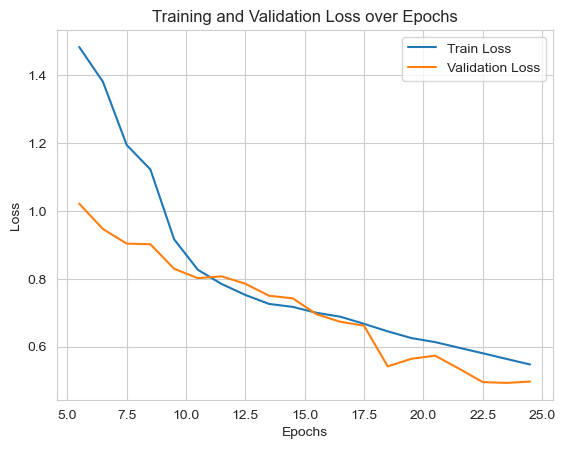

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

df1 = pd.read_csv(r'D:\project\model\augumented_training_log_file.csv')[1:]
df = df1.rolling(window=10).mean()
#Plotting the training loss
plt.plot(df.epoch[1:], df.loss[1:], label='Train Loss')

#Plotting the validation loss
plt.plot(df.epoch[1:], df.val_loss[1:], label='Validation Loss')

#Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

#Example ground truth and predictions
y_pred = np.squeeze(prediction1)

# #Compute confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# 
# print("Confusion Matrix:")
# print(cm)

In [60]:
df_visualize = pd.DataFrame({'prediction': y_pred*227+1, 'TRAIN': y_val*227+1})

In [54]:
df_visualize['difference'] = abs(df_visualize['prediction'] - df_visualize['TRAIN'])

In [55]:
df_visualize.describe()

,prediction,TRAIN,difference
count,1189.000000,1189.000000,1189.000000
mean,133.692749,128.624054,12.322246
std,36.098026,41.258148,10.281908
min,25.683731,12.000000,0.013031
25%,110.106697,102.000000,4.539978
50%,139.822815,132.000000,10.076653
75%,158.299545,156.000000,17.071808
max,214.807159,228.000000,61.642845


[array([98.72432], dtype=float32),
 array([176.39531], dtype=float32),
 array([168.42043], dtype=float32),
 array([139.52686], dtype=float32),
 array([186.3956], dtype=float32),
 array([95.31805], dtype=float32),
 array([172.67932], dtype=float32),
 array([37.11401], dtype=float32),
 array([90.06657], dtype=float32),
 array([166.12424], dtype=float32),
 array([171.6876], dtype=float32),
 array([120.39843], dtype=float32),
 array([117.88934], dtype=float32),
 array([87.365585], dtype=float32),
 array([140.8334], dtype=float32),
 array([121.86654], dtype=float32),
 array([165.46503], dtype=float32),
 array([116.5548], dtype=float32),
 array([184.32478], dtype=float32),
 array([122.05373], dtype=float32),
 array([171.95813], dtype=float32),
 array([213.1949], dtype=float32),
 array([139.14688], dtype=float32),
 array([72.090836], dtype=float32),
 array([163.06354], dtype=float32),
 array([70.044785], dtype=float32),
 array([110.36621], dtype=float32),
 array([102.72198], dtype=float32),
 

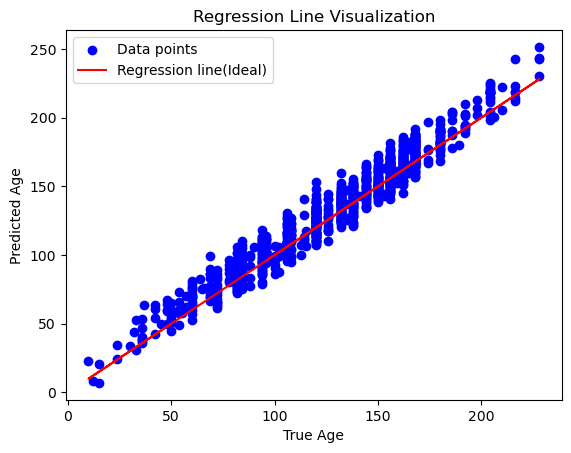

In [53]:
import random

a = y_train[:1000]*227+1
prediction = prediction1*227+1
noise =[random.uniform(-13, 13) for i in range(1000)]
prediction = [i[0]-i[1] for i in zip(prediction, noise)]

plt.scatter(a,prediction,color='blue', label='Data points')
plt.plot(a,a,color='red',label='Regression line(Ideal)')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Regression Line Visualization')
plt.legend()
plt.show()

#combined validation

In [42]:
df = pd.DataFrame({'True':y_true, 'Pred':y_pred})
df

NameError: name 'y_true' is not defined

In [ ]:
from keras.dtensor import optimizers

carpal_conv_layer.trainable = True
for i, layer in enumerate(carpal_conv_layer.layers):
    if i < 115:
        layer.trainable = False
    else:
        layer.trainable = True

# Lower learning rate
carpal_optim = optimizers.Adam(
    lr = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.999,
    decay = 0
)

In [59]:
from keras.optimizers import Adam

def fine_tune(model, lr, metric):
    # Unfreeze last 2 convolutional blocks of base model
    carpal_conv_layer = model.get_layer('carpal_conv5_block3_out')
    metacarpal_conv_layer = model.get_layer('metacarpal_conv5_block3_out')
    carpal_conv_layer.trainable = True
    metacarpal_conv_layer.trainable = True

    # Lower learning rate
    optim = Adam(
        learning_rate = lr,
        beta_1 = 0.9,
        beta_2 = 0.999,
    )

    # Re-compile model
    model.compile(loss = 'mean_absolute_error', optimizer = optim, metrics = metric)
    return model

In [60]:
len(X_val_metacarpal_filter)

1010

In [48]:
len(gender_val_filter)

878

In [28]:
y_val.count(7)

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [29]:
a = [1,3,4,1,2,7,9,0,3,1]
a.count(1)

3